In [1]:
import glob 
import netCDF4 as nc
import numpy as np
import os
import h5py
import torch


from matplotlib import colors, pyplot as plt
from datetime import timedelta, datetime

In [2]:
def read_data(
    data_dir="../ldcast/ldcast/data/demo/20210622",
    t0=datetime(2021,6,22,18,35),
    interval=timedelta(minutes=5),
    past_timesteps=4,
    crop_box=((128,480), (160,608))
):
    cb = crop_box
    R_past = []
    t = t0 - (past_timesteps-1) * interval
    for i in range(past_timesteps):
        timestamp = t.strftime("%y%j%H%M")
        fn = f"RZC{timestamp}VL.801.h5"
        fn = os.path.join(data_dir, fn)
        with h5py.File(fn, 'r') as f:
            R = f["dataset1"]["data1"]["data"][:]
        R = R[cb[0][0]:cb[0][1], cb[1][0]:cb[1][1]]
        R_past.append(R)
        t += interval

    R_past = np.stack(R_past, axis=0)
    return R_past

def plot_border(ax, crop_box=((128,480), (160,608))):    
    import shapefile
    border = shapefile.Reader("../ldcast/ldcast/data/Border_CH.shp")
    shapes = list(border.shapeRecords())
    for shape in shapes:
        x = np.array([i[0]/1000. for i in shape.shape.points[:]])
        y = np.array([i[1]/1000. for i in shape.shape.points[:]])
        ax.plot(
            x-crop_box[1][0]-255, 480-y-crop_box[0][0],
            'k', linewidth=1.0        
        )
        
def reverse_transform_R(R, mean=-0.051, std=0.528):
    return 10**(R*std + mean)
        
def plot_precip_image(
    ax, R,     
    Rmin=-3.1212, Rmax=4.168956, threshold_mmh=0.1,
    transform_R=False,
    grid_spacing=64
):
    if isinstance(R, torch.Tensor):
        R = R.detach().numpy()
    if transform_R:
        R = reverse_transform_R(R, mean=mean, std=std)
    Rmin = reverse_transform_R(Rmin)
    Rmax = reverse_transform_R(Rmax)
    if threshold_mmh:
        Rmin = max(Rmin, threshold_mmh)
        R[R < threshold_mmh] = np.nan
    norm = colors.LogNorm(Rmin, Rmax)
    ax.set_yticks(np.arange(0, R.shape[0], grid_spacing))
    ax.set_xticks(np.arange(0, R.shape[1], grid_spacing))
    ax.grid(which='major',alpha=0.35)

    return ax.imshow(R, norm=norm, cmap='jet')

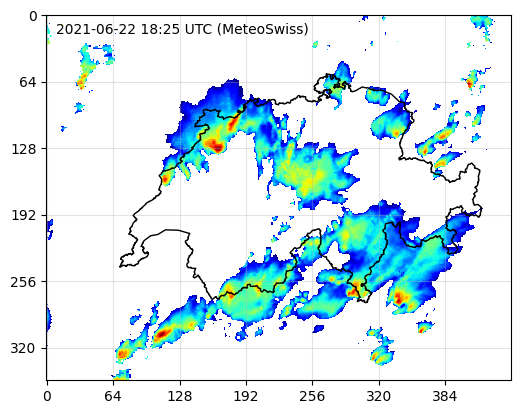

In [3]:
draw_border = True ; label = "MeteoSwiss"
t0 = datetime(2021,6,22,18,35)
past_timesteps = 4
interval = timedelta(minutes=5)

R_past = read_data(t0=t0, 
                   past_timesteps=past_timesteps,
                   interval=interval)

idx = 1 ; t = t0 - (past_timesteps-idx-1) * interval
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plot_precip_image(ax, R_past[idx])

if draw_border:
    plot_border(ax)
if t is not None:
    timestamp = "%Y-%m-%d %H:%M UTC"
    if label is not None:
        timestamp += f" ({label})"
    ax.text(
        0.02, 0.98, t.strftime(timestamp),
        horizontalalignment='left', verticalalignment='top',
        transform=ax.transAxes            
    )